### Pedalcast: Predicting daily bike usage for each station - Cleaning & EDA Notebook

#### Data Sources

This project uses two main datasets:

- **BlueBikes Trip Data**  
  Historical trip records from BlueBikes system, including start/end stations, timestamps, and bike types. The data used in this project spans July 2023 through June 2025.

  📂 Source: [BlueBikes Open Data Portal](https://s3.amazonaws.com/hubway-data/index.html)


- **Weather Data**  
  Daily weather conditions (temperature, precipitation, wind, visibility, etc.) for the Boston area, aligned with each ride day.  
  
  📂 Source: [Visual Crossing Weather](https://www.visualcrossing.com/weather-data)

These datasets are combined to train a model that predicts daily bike demand at the station level.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
from glob import glob

##### Combining Monthly Trip Data

In the cell below, we load and combine all monthly BlueBikes trip data files into a single DataFrame.

Each monthly dataset is stored as a CSV file named in the format:  
`YYYY-MM-bluebikes-tripdata.csv` inside the `data/` directory.

We use `glob` to match all relevant files, then read them into pandas DataFrames.  

In [2]:
csv_files = sorted(glob("data/*-bluebikes-tripdata.csv"))

dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
        dfs.append(df)
    except Exception as e:
        print(f"❌ Failed to load {f}: {e}")

if dfs:
    trips_all = pd.concat(dfs, ignore_index=True)
    print(f"✅ Combined shape: {trips_all.shape}")
else:
    print("❌ No CSVs loaded. Check filename pattern or folder.")

✅ Combined shape: (8793350, 13)


We keep only the columns needed for daily station-level EDA and cleaning:  
`started_at`, `start_station_name`, `start_station_id`,`start_lng`, and `end_lat` .

2033 rows are dropped due to missing start_station_id, and a `date` column is created by extracting the day from the `started_at` timestamp and converting it to a datetime object.

In [3]:
relevant_cols = ['started_at','start_station_name','start_station_id','start_lng','start_lat']
trips = trips_all[relevant_cols]
trips=trips.dropna()
trips['date'] = pd.to_datetime(pd.to_datetime(trips['started_at'],format='mixed').dt.date)
trips

,started_at,start_station_name,start_station_id,start_lng,start_lat,date
0,2023-07-18 13:48:34,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,-71.095171,42.331184,2023-07-18
1,2023-07-19 12:16:30,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,-71.095171,42.331184,2023-07-19
2,2023-07-28 17:49:26,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,-71.095171,42.331184,2023-07-28
3,2023-07-22 23:14:17,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,-71.095171,42.331184,2023-07-22
4,2023-07-21 18:41:22,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,-71.095171,42.331184,2023-07-21
...,...,...,...,...,...,...
8793345,2025-06-12 20:20:45.355,Tremont St at Northampton St,C32056,-71.081690,42.338432,2025-06-12
8793346,2025-06-25 17:13:30.010,Park Street T Stop - Tremont St at Park St,B32068,-71.062457,42.356627,2025-06-25
8793347,2025-06-09 16:03:20.398,Innovation Lab - 125 Western Ave at Batten Way,A32011,-71.124598,42.363713,2025-06-09
8793348,2025-06-03 09:22:41.353,Centre St at Seaverns Ave,E32008,-71.114050,42.313580,2025-06-03


#### Looking at Map of Stations

In [4]:
stations = trips.drop_duplicates(subset='start_station_id')
stations_gpd = gpd.GeoDataFrame(stations, geometry= gpd.points_from_xy(stations['start_lng'],stations['start_lat']),crs=4326)
stations_gpd.explore()

#### Resolving Inconsistent Station IDs

In the trip dataset, some station names appeared with multiple station IDs, likely due to ID renaming. To clean this, I identified station names linked to more than one ID and maped the old IDs to the new preferred ID to have to ensure each station name had a single identifier.

In [5]:
# Load all unique ID-name pairs
id_name_pairs = trips[['start_station_id', 'start_station_name']].drop_duplicates()

# Count how many different IDs each name is associated with
name_to_ids = id_name_pairs.groupby('start_station_name')['start_station_id'].nunique().reset_index()
suspect_names = name_to_ids[name_to_ids['start_station_id'] > 1]
problem_names = suspect_names['start_station_name'].tolist()

# Find all ID-name mappings for those names
id_name_mismatches = id_name_pairs[id_name_pairs['start_station_name'].isin(problem_names)]

# Sort for easier inspection
id_name_mismatches = id_name_mismatches.sort_values(by='start_station_name')

id_name_mismatches

,start_station_id,start_station_name
150537,A32032,Airport T Stop - Bremen St at Brooks St
1290761,A32055,Airport T Stop - Bremen St at Brooks St
3732,A32055,Bremen St at Marion St
1378259,A32032,Bremen St at Marion St
166290,V32009,Chelsea St at Vine St
971095,V32016,Chelsea St at Vine St
7063547,B32066,Commonwealth Ave at Granby St
7093947,B32060,Commonwealth Ave at Granby St
1126,S32020,Somerville Hospital
2591633,S32052,Somerville Hospital


In [6]:
# need to do this seperately because the first station's old id was reused as the new id 
# for the other station and vice versa, so I identify the row with both name and id to change them.
# Define mapping from name to correct station ID
station_name_to_id = {
    "Airport T Stop - Bremen St at Brooks St": "A32055",
    "Bremen St at Marion St": "A32032"
}

trips['start_station_id'] = trips.apply(
    lambda row: station_name_to_id.get(row['start_station_name'], row['start_station_id']),
    axis=1
)

# replace old ids with new ones
id_replacements = {
    'V32009': 'V32016',  
    'B32066': 'B32060',
    'S32020': 'S32052',
    'A32046': 'A32058',
    'A32021': 'D32022',
}
trips['start_station_id'] = trips['start_station_id'].replace(id_replacements)

#### Resolving ID–Name Conflicts

Some `start_station_id` values were associated with multiple distinct station names, likely due to station relocation or ID reuse.

To fix this:
- We identified station IDs linked to more than one name.
- After inspecting the name differences, referencing the official station list PDF, and plotting the coordinates to verify distinct locations, we resolved ID conflicts using conditional logic to map each station to the correct identifier.
- Note that I made changes to only the stations that had completely different names, typos don't matter since we will groupby later by id.

[Source](https://assets.ctfassets.net/p6ae3zqfb1e3/1Qyri2IowIRMXYGn6G0BFz/9f7a072bb8fa782cfbb209c5836f5592/External-_Bluebikes_Station_List.pdf) - Official PDF

In [7]:
# Get all unique (ID, name) pairs
id_name_pairs = trips[['start_station_id', 'start_station_name']].drop_duplicates()

# Count how many different names are associated with each ID
id_to_names = (
    id_name_pairs
    .groupby('start_station_id')['start_station_name']
    .nunique()
    .reset_index(name='name_count')
)

# Filter for IDs with more than one unique name
suspect_ids = id_to_names[id_to_names['name_count'] > 1]

# View the actual name variations for those IDs
merged_names = id_name_pairs[id_name_pairs['start_station_id'].isin(suspect_ids['start_station_id'])]\
               .sort_values('start_station_id')

merged_with_coords = merged_names.merge(
    trips[['start_station_id', 'start_station_name','start_lat','start_lng']].drop_duplicates(subset=['start_station_id', 'start_station_name']),
    on=['start_station_id', 'start_station_name'],
    how='left'
).drop_duplicates()

# Preview result
merged_names[merged_names['start_station_id'].isin(['A32058','V32016','D32022'])]

,start_station_id,start_station_name
1712908,A32058,Tremont St at Court St
83319,A32058,Canal St at Causeway St
2084210,A32058,Canal St. at Causeway St.
1980802,A32058,Tremont St. at Court St.
7510792,D32022,Nashua Street at Red Auerbach Way [Extension]
195,D32022,West End Park
166290,V32016,Chelsea St at Vine St
553648,V32016,Pope John High School


In [8]:
diff_stations = merged_with_coords[merged_with_coords['start_station_id'].isin(['A32058','V32016','D32022'])]
diff_stations_gpd = gpd.GeoDataFrame(diff_stations, geometry= gpd.points_from_xy(diff_stations['start_lng'],diff_stations['start_lat']),crs=4326)
diff_stations_gpd.explore(marker_kwds={"radius": 3})

In [9]:
# Apply mapping conditionally
trips.loc[
    (trips['start_station_id'] == 'A32058') & (trips['start_station_name'].str.contains('Causeway St', case=False, na=False)),
    'start_station_id'
] = 'A32046'

trips.loc[
    (trips['start_station_id'] == 'V32016') & (trips['start_station_name'].str.contains('Pope John High', case=False, na=False)),
    'start_station_id'
] = 'V32009'

trips.loc[
    (trips['start_station_id'] == 'D32022') & (trips['start_station_name'].str.contains('Nashua Street at Red Auerbach Way.+', case=False, na=False)),
    'start_station_id'
] = 'A32021'



Creating Daily Counts dataframe after cleaning

In [10]:
daily_counts = (
    trips.groupby(['start_station_id', 'start_station_name', 'date'])
                .size()
                .reset_index(name='trip_count')
)
daily_counts

,start_station_id,start_station_name,date,trip_count
0,A32000,Fan Pier,2023-07-01,30
1,A32000,Fan Pier,2023-07-02,20
2,A32000,Fan Pier,2023-07-03,28
3,A32000,Fan Pier,2023-07-04,35
4,A32000,Fan Pier,2023-07-05,41
...,...,...,...,...
318692,c32014,Damrell St at Old Colony Ave,2024-09-16,28
318693,c32014,Damrell St at Old Colony Ave,2024-09-17,27
318694,c32014,Damrell St at Old Colony Ave,2024-09-18,16
318695,c32014,Damrell st at Old Colony Ave,2024-08-06,5


In [11]:
weather = pd.read_csv('data/boston_weather.csv')
weather = weather[['datetime','temp','humidity','precip','snow','windspeed','visibility','cloudcover']]
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather =weather.rename({'datetime':'date'},axis=1)
weather.head()

,date,temp,humidity,precip,snow,windspeed,visibility,cloudcover
0,2023-06-30,21.5,82.3,0.000,0.0,22.0,15.4,48.3
1,2023-07-01,19.3,93.5,0.000,0.0,20.3,4.8,90.6
2,2023-07-02,20.9,89.9,8.278,0.0,28.9,7.6,98.5
3,2023-07-03,20.4,89.4,14.249,0.0,18.0,10.4,89.5
4,2023-07-04,20.1,94.4,12.163,0.0,16.4,12.0,96.0


In [12]:
daily_counts_w = daily_counts.merge(weather,on='date',how='left')
daily_counts_w

,start_station_id,start_station_name,date,trip_count,temp,humidity,precip,snow,windspeed,visibility,cloudcover
0,A32000,Fan Pier,2023-07-01,30,19.3,93.5,0.000,0.0,20.3,4.8,90.6
1,A32000,Fan Pier,2023-07-02,20,20.9,89.9,8.278,0.0,28.9,7.6,98.5
2,A32000,Fan Pier,2023-07-03,28,20.4,89.4,14.249,0.0,18.0,10.4,89.5
3,A32000,Fan Pier,2023-07-04,35,20.1,94.4,12.163,0.0,16.4,12.0,96.0
4,A32000,Fan Pier,2023-07-05,41,23.9,78.4,0.000,0.0,17.8,13.3,53.3
...,...,...,...,...,...,...,...,...,...,...,...
318692,c32014,Damrell St at Old Colony Ave,2024-09-16,28,19.0,63.7,0.000,0.0,25.2,15.9,17.5
318693,c32014,Damrell St at Old Colony Ave,2024-09-17,27,19.2,69.4,0.000,0.0,20.0,15.9,58.0
318694,c32014,Damrell St at Old Colony Ave,2024-09-18,16,18.1,87.8,0.000,0.0,14.5,13.0,81.6
318695,c32014,Damrell st at Old Colony Ave,2024-08-06,5,20.8,84.1,9.151,0.0,23.9,14.6,99.4


In [13]:
# downloading cleaned data

#daily_counts_w.to_csv("data/daily_counts_with_weather.csv", index=False)

#### EDA

##### Distribution of Daily Bike Usage (Target Variable)

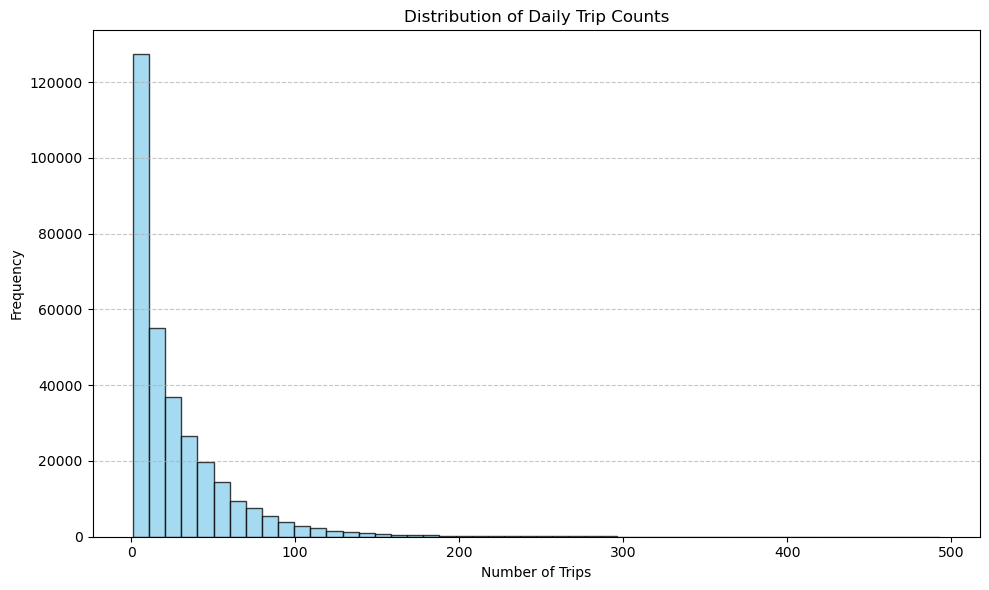

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(daily_counts_w['trip_count'], bins=50, color='skyblue', edgecolor='black', alpha=0.75)
plt.title("Distribution of Daily Trip Counts")
plt.xlabel("Number of Trips")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

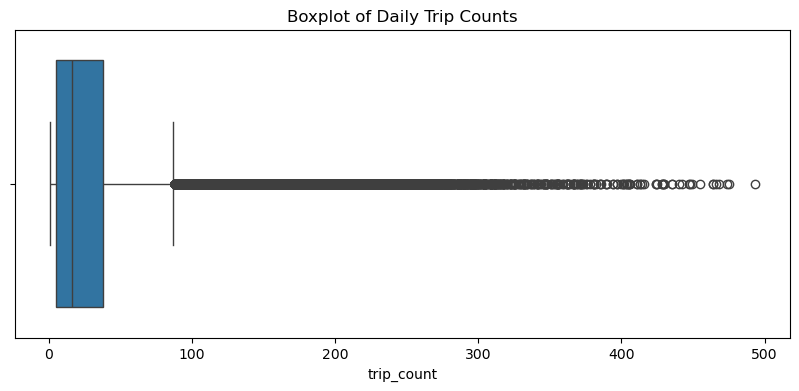

In [15]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=daily_counts_w, x='trip_count')
plt.title("Boxplot of Daily Trip Counts")
plt.show()

This histogram shows how frequently different levels of daily Bluebikes trip counts occur across all stations in the dataset.
Observations:
- Right-skewed distribution:
  - The majority of trip counts entries have fewer than 50 trips.
  - Most common daily counts are concentrated in the 0–20 trip range.

- Long tail:
  - Some stations occasionally record 100+ trips/day, and a few surpass 400.
  - These are likely high-traffic commuter or central city locations.

##### Top 10 Most Used Stations

In [16]:
daily_counts_w.groupby(['start_station_name','start_station_id'])['trip_count'].sum().sort_values(ascending=False)[:10]

start_station_name                                           start_station_id
MIT at Mass Ave / Amherst St                                 M32006              168000
Central Square at Mass Ave / Essex St                        M32011              129261
Harvard Square at Mass Ave/ Dunster                          M32018              115211
MIT Vassar St                                                M32042               96871
MIT Pacific St at Purrington St                              M32041               93428
Charles Circle - Charles St at Cambridge St                  D32016               88383
Ames St at Main St                                           M32037               85390
Christian Science Plaza - Massachusetts Ave at Westland Ave  B32005               78519
Mass Ave/Lafayette Square                                    M32085               76627
Beacon St at Massachusetts Ave                               B32016               74384
Name: trip_count, dtype: int64

#### Learning Relations between Weather Conditions and Bike Usage(Trip Count)

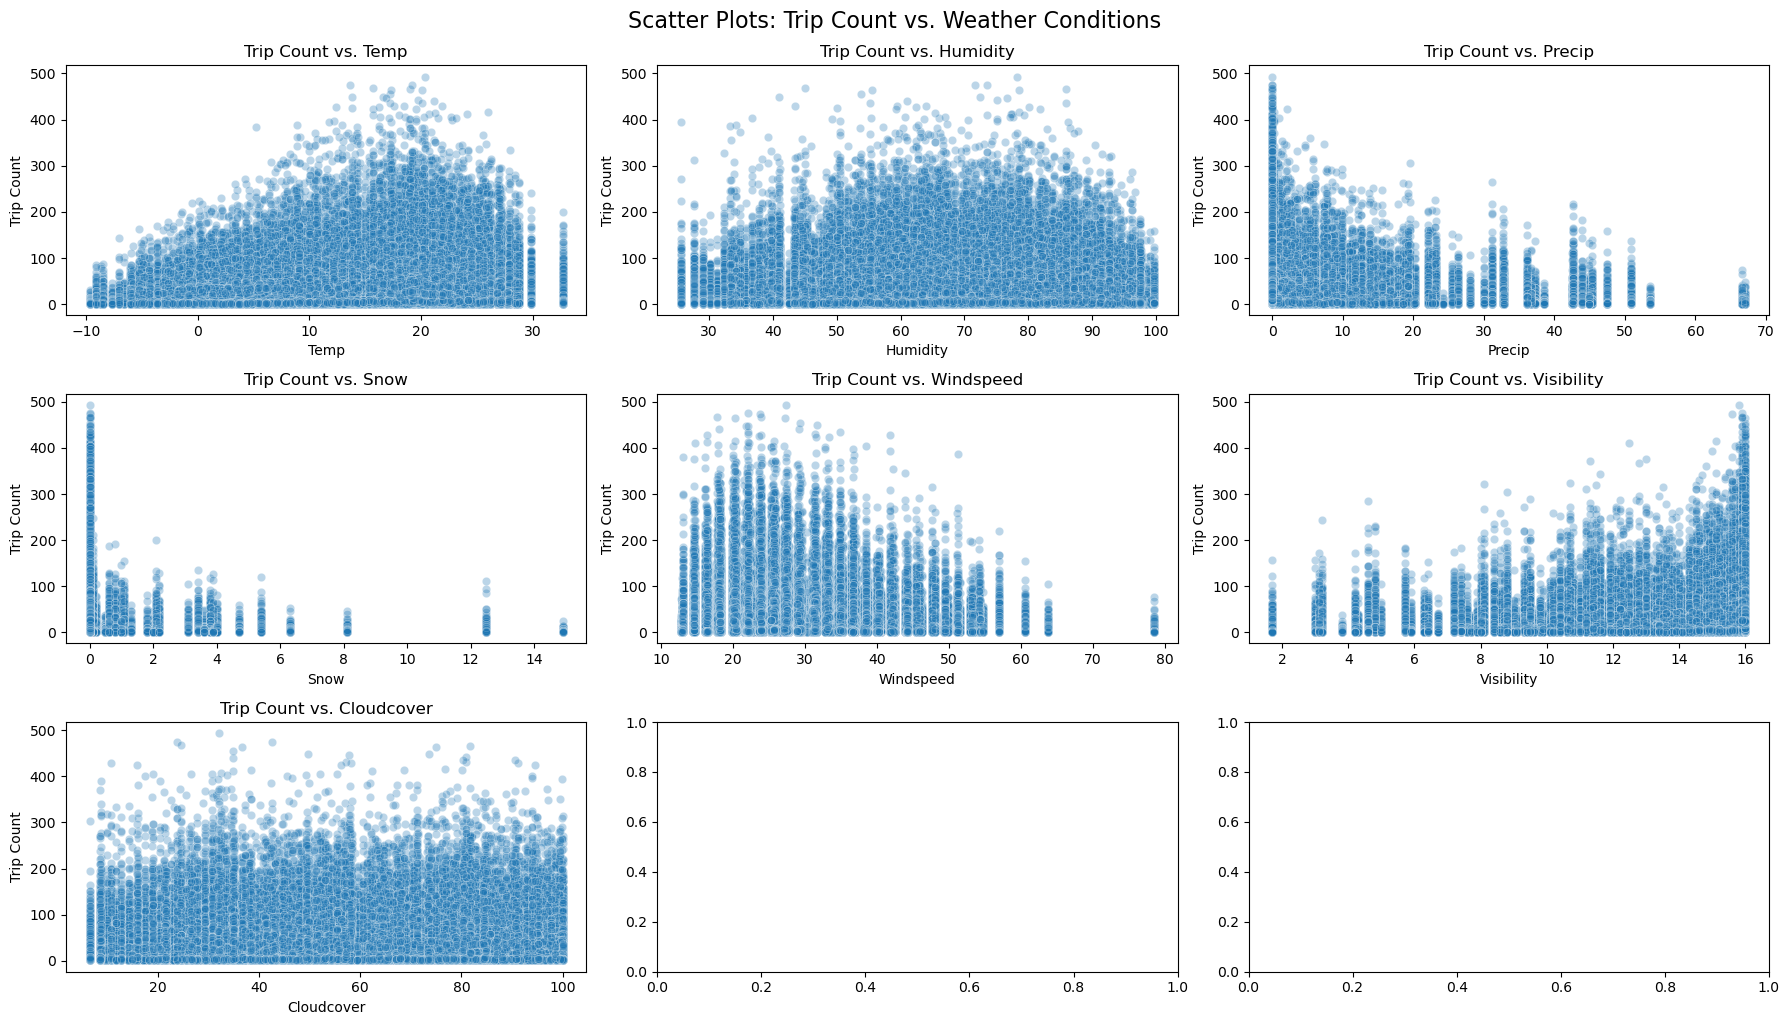

In [17]:

# List of weather features to compare
weather_vars = ['temp', 'humidity', 'precip', 'snow', 'windspeed', 'visibility','cloudcover']

# Set up figure
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(weather_vars):
    ax = axes[i]
    sns.scatterplot(
        data=daily_counts_w,
        x=var,
        y='trip_count',
        alpha=0.3,
        ax=ax
    )
    ax.set_title(f'Trip Count vs. {var.capitalize()}')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Trip Count')
plt.tight_layout()
plt.suptitle('Scatter Plots: Trip Count vs. Weather Conditions', fontsize=16, y=1.02)
plt.show()

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_17176/2143631813.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = daily_counts_w2.groupby(f'{var}_bin')['trip_count'].mean().reset_index()
/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_17176/2143631813.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_17176/2143631813.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


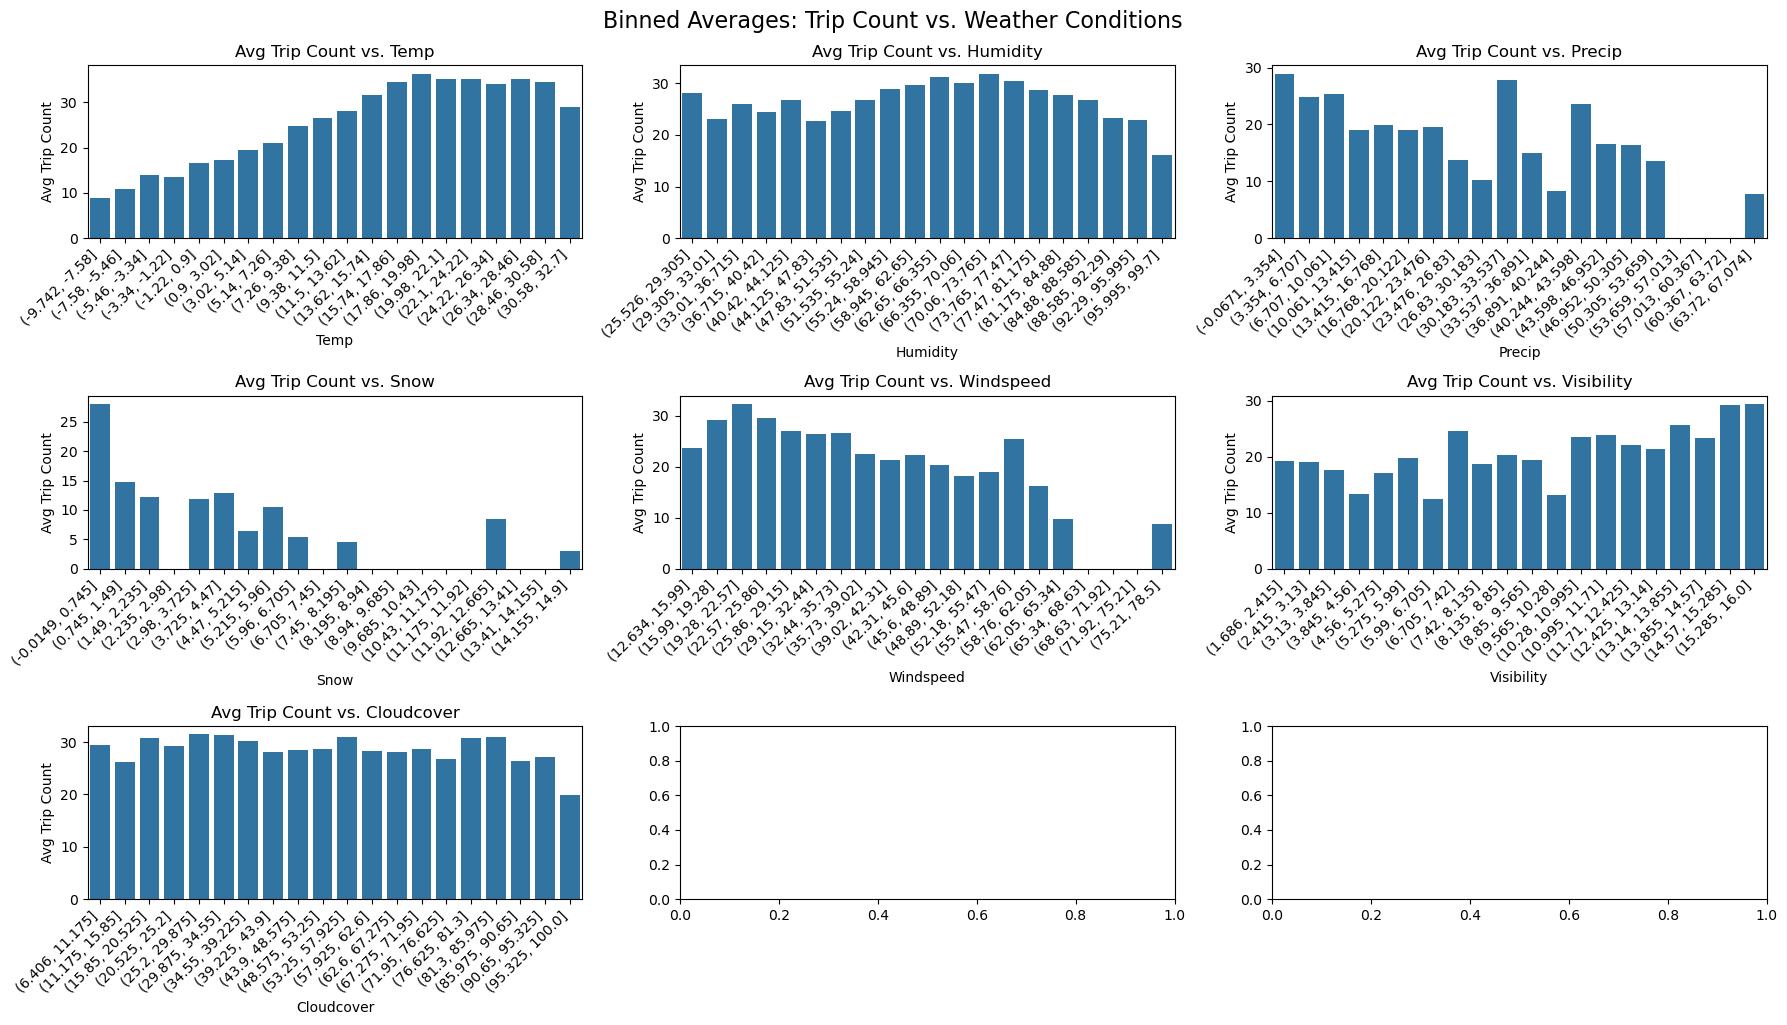

In [18]:
weather_vars = ['temp', 'humidity', 'precip', 'snow', 'windspeed', 'visibility','cloudcover']

fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()
daily_counts_w2 = daily_counts_w.copy()
for i, var in enumerate(weather_vars):
    # Bin the variable
    daily_counts_w2[f'{var}_bin'] = pd.cut(daily_counts_w2[var], bins=20)
    grouped = daily_counts_w2.groupby(f'{var}_bin')['trip_count'].mean().reset_index()

    # Plot
    ax = axes[i]
    sns.barplot(x=f'{var}_bin', y='trip_count', data=grouped, ax=ax)
    ax.set_title(f'Avg Trip Count vs. {var.capitalize()}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Avg Trip Count')
plt.tight_layout()
plt.suptitle('Binned Averages: Trip Count vs. Weather Conditions', fontsize=16, y=1.02)
plt.show()

We examine the relationship between daily trip counts and various weather variables using scatterplots and bar plots of binned averages. Below is a summary of the observed trends:

##### Temperature (`temp`)
- Strong positive trend: As temperature increases from below freezing to ~20°C, trip counts rise steadily.
- Plateaus or dips above ~25–30°C, possibly due to heat discomfort.
- Ideal range for biking appears to be 15–25°C.

##### Humidity (`humidity`)
- Bell-shaped pattern: peak bike usuage at humidity (~60–75%).
- Fewer trips at both very low (<40%) and very high (>90%) levels.

##### Precipitation (`precip`)
- Strong negative correlation: demand drops sharply as rain increases.
- Most trips occur at 0 mm precipitation.
- Negative Relationship

##### Snow (`snow`)
- Very low usage when any measurable snow is present.
- Negative Relationship

##### Windspeed (`windspeed`)
- General negative trend after 23 km/h wind speeds.

##### Visibility (`visibility`)
- Positive correlation: more trips on clear, high-visibility days (12–16 km).
- Low-visibility days (e.g., fog, storm) show less demand.
- Positive Relationship
##### Cloudcover (`cloudcover`)
- relatively flat. However, very high cloudcover decreases trip count.
- Can still improve model with interactions with other weather conditions


#### Bike Usage(Trip Count) over Time

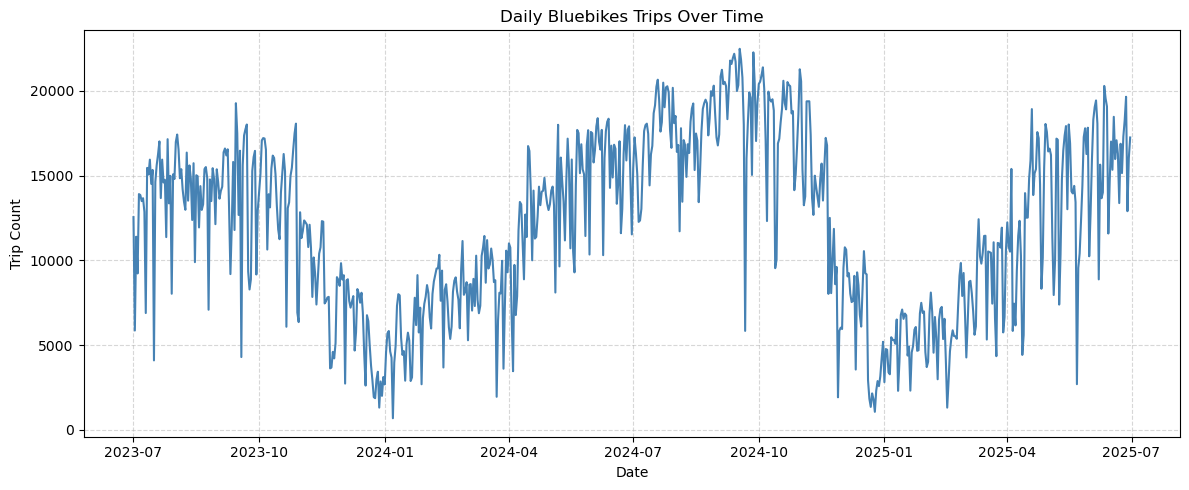

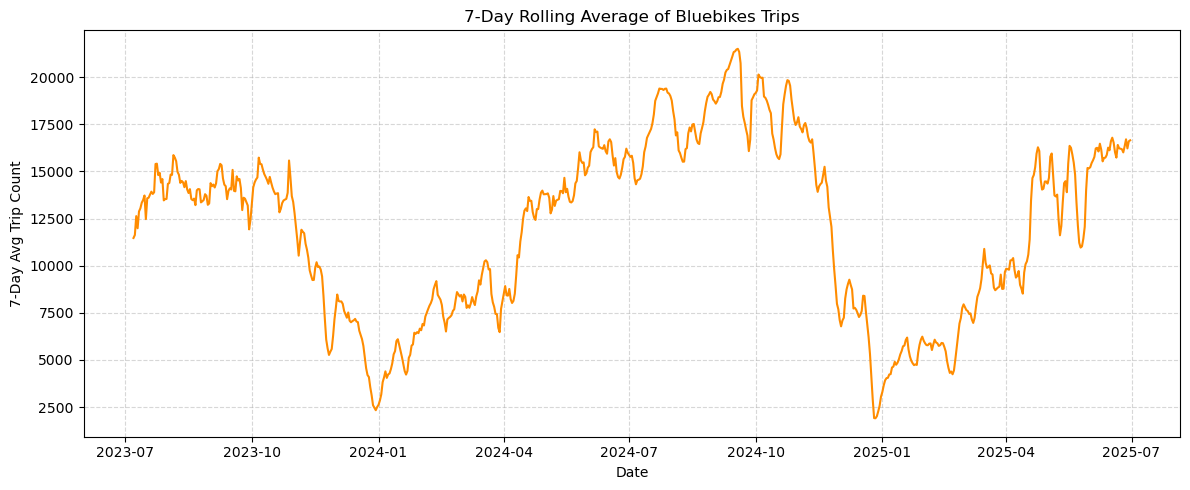

In [19]:
# Ensure datetime and rolling average are computed
daily_total = daily_counts_w.groupby('date')['trip_count'].sum().reset_index()
daily_total['rolling_7'] = daily_total['trip_count'].rolling(7).mean()

# Plot 1: Raw Daily Trip Count
plt.figure(figsize=(12, 5))
plt.plot(daily_total['date'], daily_total['trip_count'], color='steelblue')
plt.title('Daily Bluebikes Trips Over Time')
plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot 2: 7-Day Rolling Average
plt.figure(figsize=(12, 5))
plt.plot(daily_total['date'], daily_total['rolling_7'], color='darkorange')
plt.title('7-Day Rolling Average of Bluebikes Trips')
plt.xlabel('Date')
plt.ylabel('7-Day Avg Trip Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Observations:

- Clear seasonal fluctuations: usage dips sharply in winter months (Dec–Feb) and rises in spring/summer.
- Notable troughs are visible around late December and early January, aligning with the winter holiday season.

Based on these observations, we will create new features later on:
- **`is_us_holiday`**: A binary variable indicating whether a given date is a U.S. federal holiday.

This addition helps the model capture abrupt dips in ridership caused by national holidays, particularly around Christmas, New Year's Day, and other holidays like Independence Day and Thanksgiving  

- **`season`**: A categorical variable derived from the date's month, helping capture broad seasonal effects on demand (e.g., winter dips, summer peaks).


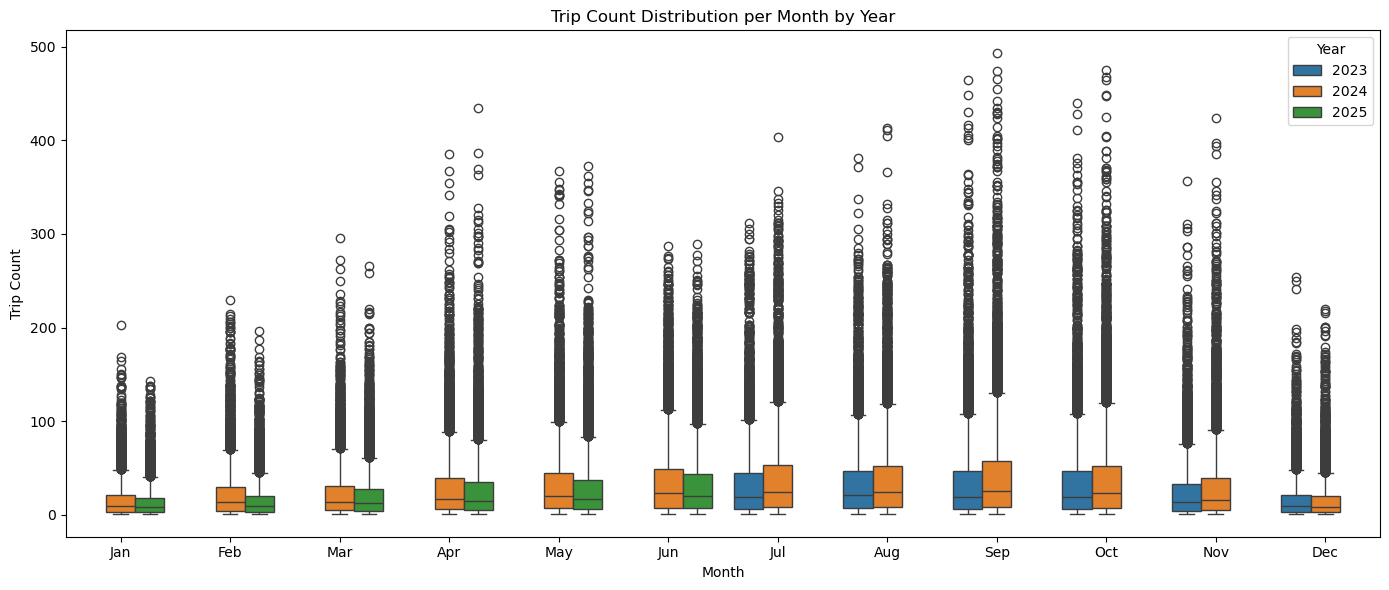

In [20]:
daily_counts_w3 = daily_counts_w.copy()
# Create year and month columns
daily_counts_w3['year'] = daily_counts_w3['date'].dt.year
daily_counts_w3['month'] = daily_counts_w3['date'].dt.strftime('%b')  # abbreviated month names
daily_counts_w3['month_num'] = daily_counts_w3['date'].dt.month       # for sorting

# Sort months so Jan → Dec
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

year_palette = {
    2023: "#1f77b4",  # blue
    2024: "#ff7f0e",  # orange
    2025: "#2ca02c"   # green
}

# Grouped by year to spot yearly differences
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=daily_counts_w3,
    x='month',
    y='trip_count',
    hue='year',
    order=month_order,
    palette=year_palette
)

plt.title('Trip Count Distribution per Month by Year')
plt.xlabel('Month')
plt.ylabel('Trip Count')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

- The spread (variance) of trip counts across months remains relatively consistent over time, even as the overall level of trips fluctuates.
- This pattern indicates that seasonal effects are independent of trend magnitude, a key characteristic of additive seasonality.

Based on this, we treat seasonality in an additive manner when engineering features or considering model assumptions.

#### Bike Usage Average Per Month

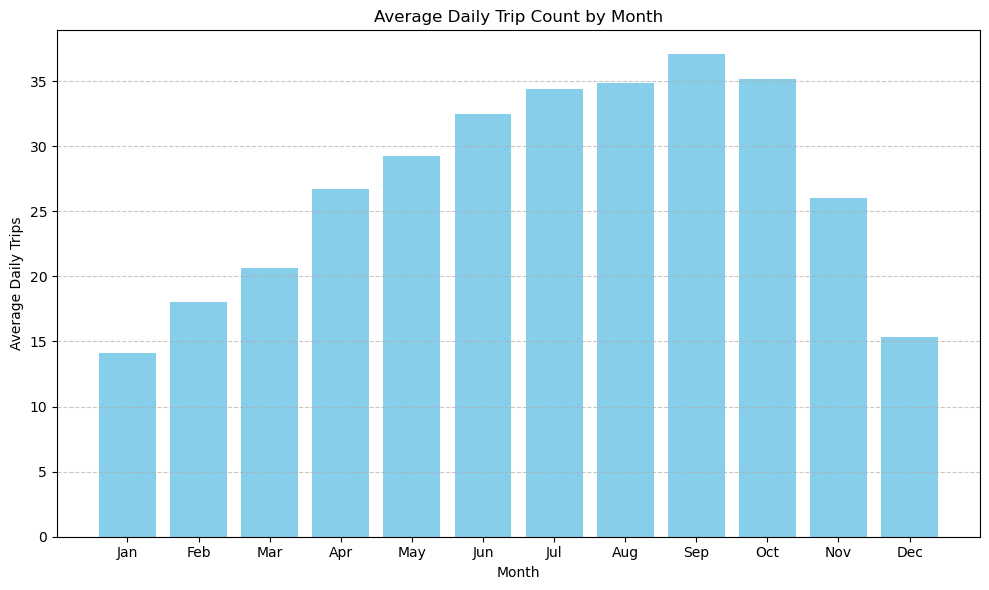

In [21]:
# Group by month and calculate mean trip count
monthly_avg = (
    daily_counts_w
    .assign(month=daily_counts_w['date'].dt.strftime('%b'),
            month_num=daily_counts_w['date'].dt.month)
    .groupby(['month_num', 'month'])['trip_count']
    .mean()
    .sort_index()
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_avg['month'], monthly_avg['trip_count'], color='skyblue')

plt.title('Average Daily Trip Count by Month')
plt.xlabel('Month')
plt.ylabel('Average Daily Trips')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This bar plot illustrates the average number of daily Bluebikes trips per month.

Key Observations:

- Seasonal Pattern: Ridership steadily increases from winter through summer, peaking in **September**, and then declines again in the colder months.
- Peak Usage: July to September show the highest average trip counts, likely driven by warm weather and increased outdoor activity.
- Low Usage: January and December have the lowest usage, consistent with Boston’s winter weather.

#### Daily Bike Usage over Time per Station

In [22]:
top_stations = (
    daily_counts_w
    .groupby('start_station_id')['trip_count']
    .sum()
    .sort_values(ascending=False)
    .sample(2)
    .index
)
top_station_df = daily_counts_w[daily_counts_w['start_station_id'].isin(top_stations)]

fig = px.line(
    top_station_df,
    x='date',
    y='trip_count',
    color='start_station_id',
    title='Daily Bike Usage Over Time',
    labels={'trip_count': 'Trips', 'start_station_id': 'Station ID'}
)

fig.update_layout(legend_title_text='Station ID')
fig.show()

Running this cell many times, I noted that many stations close from 10-15 November till 10-15 April each year.

Additionally, some stations are new and started recently in 2025.

Because of this, when I make my forecasting function in the next notebook, I'll make sure to not predict stations when they are on their time of seasonal inactivity.

#### Trip Patterns by Day of the Week


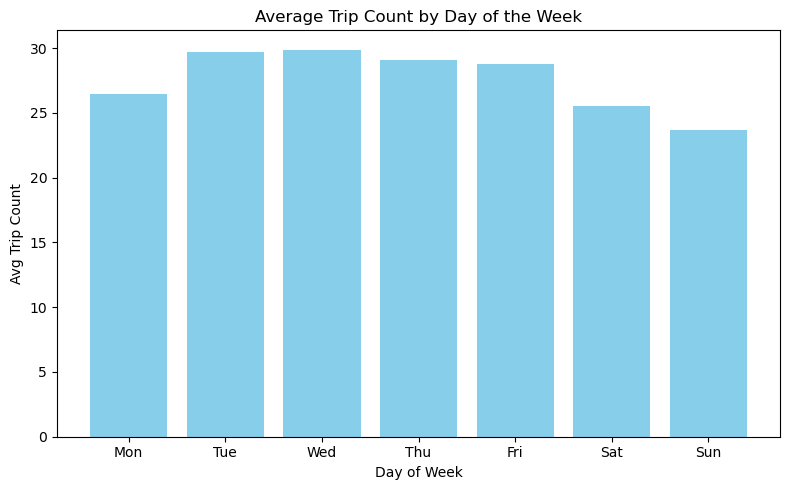

In [23]:
# Assume 'daily_counts_w' is your DataFrame with 'date' and 'trip_count' columns
daily_counts_w['date'] = pd.to_datetime(daily_counts_w['date'])
daily_counts_w['dayofweek'] = daily_counts_w['date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Compute average trips per day of week
avg_by_day = (
    daily_counts_w.groupby('dayofweek')['trip_count']
    .mean()
    .reset_index()
)

# Optional: map day numbers to names for readability
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
avg_by_day['day_name'] = avg_by_day['dayofweek'].map(dict(zip(range(7), day_labels)))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(avg_by_day['day_name'], avg_by_day['trip_count'], color='skyblue')
plt.title('Average Trip Count by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Avg Trip Count')
plt.tight_layout()
plt.show()

To investigate behavioral trends in Bluebikes usage, we plotted the average daily trip count by day of the week. Data shows:

- Higher usage on weekdays
- Lower usage on weekends, with Sunday having the lowest average trip count.

This suggests that Bluebikes are primarily used for commuting purposes, particularly on workdays and university days. Many stations are concentrated in business districts and universities. This makes sense because Boston is a very walkable city.

We will create two features later on:
- `dayofweek` — to capture cyclical weekday trends
- `is_weekend` — to indicate weekends vs. weekdays